In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [11]:
# Read names from file
with open("names.txt", "r") as f:
    names = f.readlines()

In [12]:
names = [name.strip() for name in names]
names[:3]

['emma', 'olivia', 'ava']

In [4]:
# Clean the names
# import re
# names = [re.sub('[-,.]', '', name) for name in names]
# names = [re.sub(r'\(.*\)', '', name) for name in names]
# names = [name.lower() for name in names]

In [13]:
len(names)

32033

In [14]:
# Shortest name
temp = [len(name) for name in names]
names[np.argmin(temp)]

'an'

In [15]:
min(len(name) for name in names)

2

In [16]:
max(len(name) for name in names)

15

In [17]:
# Create a set of all the characters that appear in the names and add '.' which works as start and end token
word_set = set('.')
for name in names:
    for char in list(name):
        word_set.add(char)

In [18]:
len(word_set)

27

In [19]:
# Create a matrix of all ones (not zeros for model smoothing) to store the frequency of the occurence of a bigram
word_map = torch.ones((len(word_set), len(word_set)), dtype=torch.int32)

In [20]:
word_map.sum()

tensor(729)

In [21]:
# Create a mapping from the character to its integer value
stoi = {s: i for i, s in enumerate(sorted(word_set))}

In [22]:
# Create a dictionary to map the integer value to its character
itos = {i: s for s, i in stoi.items()}

In [23]:
# Populate the lookup matrix to store the frequency of all the bigrams
for name in names:
    name = ['.'] + list(name) + ['.']
    for char1, char2 in zip(name, name[1:]):
        word_map[stoi[char1], stoi[char2]] +=1
        
word_map[:2]

tensor([[   1, 4411, 1307, 1543, 1691, 1532,  418,  670,  875,  592, 2423, 2964,
         1573, 2539, 1147,  395,  516,   93, 1640, 2056, 1309,   79,  377,  308,
          135,  536,  930],
        [6641,  557,  542,  471, 1043,  693,  135,  169, 2333, 1651,  176,  569,
         2529, 1635, 5439,   64,   83,   61, 3265, 1119,  688,  382,  835,  162,
          183, 2051,  436]], dtype=torch.int32)

In [24]:
def get_occurences(char1, char2):
    return word_map[stoi[char1], stoi[char2]].item()

get_occurences('l', 'i')

2481

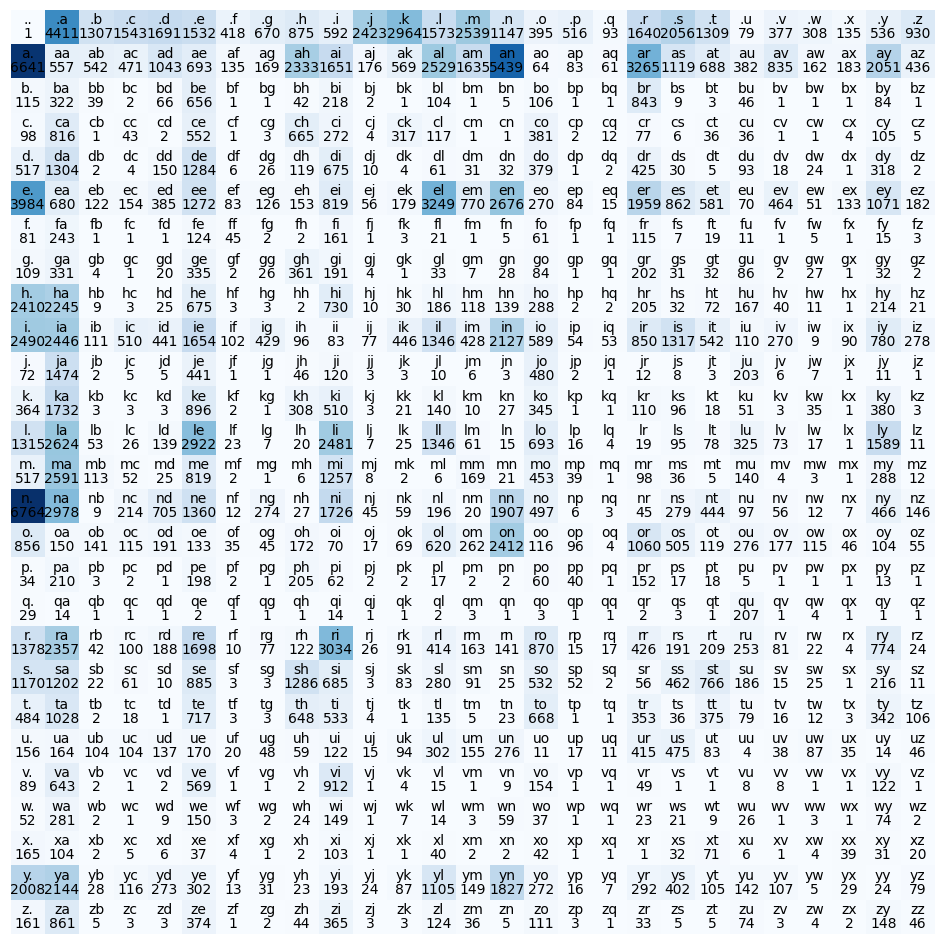

In [25]:
fig, ax = plt.subplots(figsize=(16,12))
ax.imshow(word_map, cmap="Blues")
ax.axis("off")
for i in range(len(word_set)):
    for j in range(len(word_set)):
        lbl = itos[i] + itos[j]
        plt.text(j, i, lbl, ha="center", va="bottom")
        plt.text(j, i, word_map[i,j].item(), ha="center", va="top")

In [26]:
get_occurences('r', 'e')

1698

In [27]:
torch.sum(word_map, dim=1, keepdim=True)

tensor([[32060],
        [33912],
        [ 2672],
        [ 3559],
        [ 5523],
        [20450],
        [  932],
        [ 1954],
        [ 7643],
        [17728],
        [ 2927],
        [ 5067],
        [13985],
        [ 6669],
        [18354],
        [ 7961],
        [ 1053],
        [  299],
        [12727],
        [ 8133],
        [ 5597],
        [ 3162],
        [ 2600],
        [  956],
        [  724],
        [ 9803],
        [ 2425]])

In [28]:
word_map_normal = torch.div(word_map, torch.sum(word_map, dim=1, keepdim=True))

In [29]:
torch.sum(word_map_normal, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [30]:
word_map_normal.dtype

torch.float32

In [32]:
# Generate some names using the lookup matrix
gen = torch.Generator().manual_seed(2147483647)
idx = 0
for i in range(5):
    out = []
    while True:
        idx = torch.multinomial(word_map_normal[idx], num_samples=1, replacement=True, generator=gen).item()
        if idx == 0:
            break
        out.append(itos[idx])
    print("", "".join(out))
    

 junide
 janasah
 p
 cony
 a


In [34]:
# Calculate the negative loss likelihood value which is the loss function in this case
log_likelihood = 0.0
num_samples = 0
for name in names:
    name = ['.'] + list(name) + ['.']
    for char1, char2 in zip(name, name[1:]):
        prob = word_map_normal[stoi[char1], stoi[char2]]
        log_likelihood += torch.log(prob)
        num_samples += 1
        
print(log_likelihood)
neg_ll = -log_likelihood
print(neg_ll/num_samples)

tensor(-559951.5625)
tensor(2.4544)


In [35]:
# Create the training set with inputs and targets
xs = []
ys = []
for name in names:
    name = ['.'] + list(name) + ['.']
    for char1, char2 in zip(name, name[1:]):
        xs.append(stoi[char1])
        ys.append(stoi[char2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(f"Number of samples: {xs.nelement()}")

Number of samples: 228146


In [36]:
# Change the inputs to one hot encodings
x_oh = torch.nn.functional.one_hot(xs, num_classes=27).float()
weights = torch.randn((27, 27), requires_grad=True, generator=gen) # Initialize a 27 neurons with random weights
x_oh.shape

torch.Size([228146, 27])

In [40]:
# Training loop
for _ in range(500):
    logits = torch.matmul(x_oh, weights) # Get the logits from doing a forward pass
    counts = logits.exp() # Exponentiate the logits
    probs = torch.div(counts, torch.sum(counts, dim=1, keepdims=True)) # Get the probability distribution (exponentiation and normalization = softmax)
    # Calculate the negative log lokelihood and use add regularization
    loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() + 0.01 * (weights ** 2).mean() 
    print(f"Loss: {loss.item()}")
    weights.grad = None
    loss.backward()
    # Update weights in the opposite direction of gradients
    weights.data += -50 * weights.grad

Loss: 2.480504274368286
Loss: 2.480503797531128
Loss: 2.4805033206939697
Loss: 2.4805028438568115
Loss: 2.4805023670196533
Loss: 2.480502128601074
Loss: 2.480501890182495
Loss: 2.480501413345337
Loss: 2.4805009365081787
Loss: 2.4805004596710205
Loss: 2.4804999828338623
Loss: 2.480499744415283
Loss: 2.480499267578125
Loss: 2.480499029159546
Loss: 2.480498790740967
Loss: 2.4804978370666504
Loss: 2.4804978370666504
Loss: 2.480497360229492
Loss: 2.480496883392334
Loss: 2.480496406555176
Loss: 2.480496406555176
Loss: 2.4804959297180176
Loss: 2.4804954528808594
Loss: 2.480494976043701
Loss: 2.480494499206543
Loss: 2.4804940223693848
Loss: 2.4804937839508057
Loss: 2.4804937839508057
Loss: 2.4804930686950684
Loss: 2.4804928302764893
Loss: 2.480492353439331
Loss: 2.480492353439331
Loss: 2.4804916381835938
Loss: 2.4804911613464355
Loss: 2.4804911613464355
Loss: 2.4804904460906982
Loss: 2.4804904460906982
Loss: 2.480489730834961
Loss: 2.480489492416382
Loss: 2.4804892539978027
Loss: 2.48048901557

Loss: 2.4804301261901855
Loss: 2.4804298877716064
Loss: 2.4804298877716064
Loss: 2.4804298877716064
Loss: 2.4804301261901855
Loss: 2.4804298877716064
Loss: 2.4804296493530273
Loss: 2.4804296493530273
Loss: 2.4804294109344482
Loss: 2.480429172515869
Loss: 2.4804294109344482
Loss: 2.480429172515869
Loss: 2.4804294109344482
Loss: 2.480428695678711
Loss: 2.480428695678711
Loss: 2.48042893409729
Loss: 2.480428695678711
Loss: 2.480428457260132
Loss: 2.480428457260132
Loss: 2.4804282188415527
Loss: 2.4804282188415527
Loss: 2.480428457260132
Loss: 2.4804279804229736
Loss: 2.4804279804229736
Loss: 2.4804282188415527
Loss: 2.4804277420043945
Loss: 2.4804279804229736
Loss: 2.4804275035858154
Loss: 2.4804277420043945
Loss: 2.4804275035858154
Loss: 2.4804272651672363
Loss: 2.4804275035858154
Loss: 2.4804270267486572
Loss: 2.4804272651672363
Loss: 2.4804270267486572
Loss: 2.4804272651672363
Loss: 2.4804272651672363
Loss: 2.480426549911499
Loss: 2.480426549911499
Loss: 2.480426549911499
Loss: 2.48042

In [130]:
ys.shape

torch.Size([61854])

In [38]:
# Get some sample names from the network and check if the predictions are same as the ones from the bigram lookup table previously
gen = torch.Generator().manual_seed(2147483647)
for _ in range(5):
    out = []
    idx = 0
    
    while True:
        x_enc = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = torch.matmul(x_enc, weights)
        counts = logits.exp()
        probs = torch.div(counts, torch.sum(counts, dim=1, keepdims=True))
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=gen).item()
        if idx == 0:
            break
        out.append(itos[idx])
        

    print("".join(out))

junide
janasah
prelay
a
nn
